In this notebook I take the data that was produced in the descriptive analysis section and fit a generalized radiation model (GRM) to the data.

In [590]:
import pandas as pd
pre_kincaid = pd.read_csv('../data/clean/pre_kincaid.csv')
pre_kincaid = pre_kincaid[pre_kincaid['county_o'] != pre_kincaid.county_d]
pre_kincaid = pre_kincaid.merge(pre_kincaid.groupby('geoid_o')[['pop_flows']].sum().rename({'pop_flows':'outflow'}, axis=1), on = 'geoid_o', how='left')
pre_kincaid['coord_o'] = pd.Series(pre_kincaid[['lat_o','lng_o']].itertuples(index=False, name=None))
pre_kincaid['coord_d'] = pd.Series(pre_kincaid[['lat_d','lng_d']].itertuples(index=False, name=None))

This is a class to fit and predict with a generalized radiation model

In [591]:
from geopy.distance import geodesic
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize

class GeneralizedRadiationModel:
    def __init__(self):
        self.X_cols_i = None
        self.X_cols_j = None
        self.weights = None

    def point_in_circle(self, origin, destination, point):
        origin_destination_distance = geodesic(origin, destination).meters
        origin_point_distance = geodesic(origin, point).meters
        return ((origin_point_distance <= origin_destination_distance) and (point != origin) and (point != destination))

    def calculate_v_ij_pre_weight(self, df):
        v_ij_pre_weight = df.apply(lambda row: df.loc[df.coord_d.apply(lambda x: self.point_in_circle(row['coord_o'], row['coord_d'], x)), self.X_cols_j].sum(), axis=1)
        return v_ij_pre_weight

    def radiation_model(self, T_i, U_i, U_j, v_ij, weights):

        weighted_U_i = U_i @ weights
        weighted_U_j = U_j @ weights
        weighted_v_ij = v_ij @ weights

        return T_i * (weighted_U_i * weighted_U_j) / ((weighted_U_i + weighted_v_ij) * (weighted_U_i + weighted_U_j + weighted_v_ij))

    def fit(self, df, coord_cols, X_cols_i, X_cols_j, T_i_col, T_ij_col):
        self.X_cols_i = X_cols_i
        self.X_cols_j = X_cols_j
        self.outflow_col = T_i_col

        coord_df = df[coord_cols]
        X_i = df[X_cols_i].values
        X_j = df[X_cols_j].values
        T_i = df[T_i_col].values
        T_ij = df[T_ij_col].values

        v_ij_pre_weight = self.calculate_v_ij_pre_weight(df)
        self.v_ij = v_ij_pre_weight

        def error_function(weights, *args):
            fitted_T_ij = self.radiation_model(T_i, X_i, X_j, v_ij_pre_weight, weights)
            residuals = fitted_T_ij - T_ij
            return np.sum(residuals**2)

        # Initial weight values (can be adjusted based on your requirements)
        initial_weights = np.ones(len(X_cols_j))

        # # Perform the optimization process
        # optimal_weights, _ = curve_fit(self.ra None, T_ij, initial_weights)

        self.optimal_result = minimize(error_function, x0 =  initial_weights, method = 'Nelder-Mead')

        self.weights = self.optimal_result.x

    def predict(self, df):
        v_ij = self.calculate_v_ij_pre_weight(df)
        return self.radiation_model(df[self.outflow_col].values, df[self.X_cols_i].values, df[self.X_cols_j].values, v_ij.values, self.weights)

Before fitting, let's scale the x variables.

In [592]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Define the logistic z-score transformation function
def logistic_zscore(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    transformed_x = 1 / (1 + np.exp(-(x - x_mean) / x_std))
    return transformed_x

# Create a FunctionTransformer with the logistic z-score transformation function
scaler = FunctionTransformer(logistic_zscore)

pre_kincaid[['pop_o','pop_d',]] = scaler.fit_transform(pre_kincaid[['pop_o','pop_d',]])

In [593]:
grm = GeneralizedRadiationModel()
grm.fit(pre_kincaid, ['coord_o','coord_d'], ['pop_o', 'eigen_centrality_o'], ['pop_d','eigen_centrality_d'], 'outflow','pop_flows')

predicted = grm.predict(pre_kincaid)
pre_kincaid['predicted_flow'] = predicted
pre_kincaid[['v_ij_pop', 'v_ij_centrality']] = grm.v_ij

<Axes: xlabel='predicted_flow', ylabel='pop_flows'>

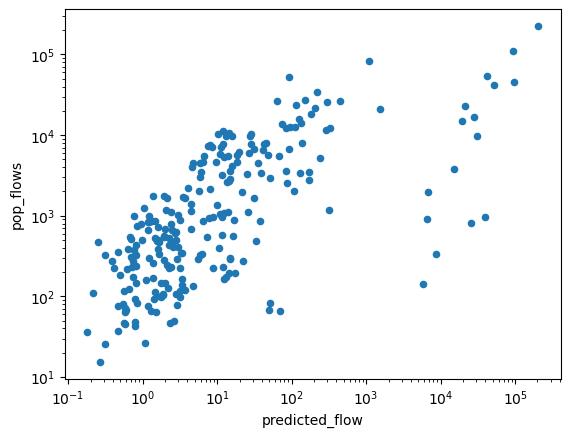

In [594]:
pre_kincaid.plot.scatter(x='predicted_flow', y='pop_flows', logx=True, logy=True)

In [595]:
grm_2 = GeneralizedRadiationModel()
grm_2.fit(pre_kincaid, ['coord_o','coord_d'], ['pop_o'], ['pop_d'], 'outflow','pop_flows')

predicted = grm_2.predict(pre_kincaid)
pre_kincaid['predicted_flow'] = predicted
pre_kincaid[['v_ij_pop']] = grm_2.v_ij

<Axes: xlabel='predicted_flow', ylabel='pop_flows'>

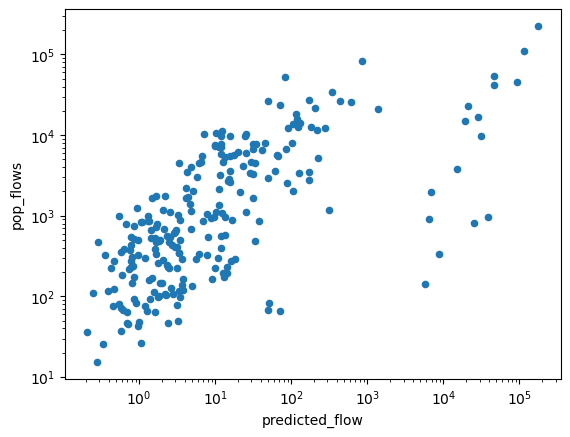

In [599]:
pre_kincaid.plot.scatter(x='predicted_flow', y='pop_flows', logx=True, logy=True)

In [602]:
(grm_2.optimal_result['fun'] - grm.optimal_result['fun'])/grm_2.optimal_result['fun']

0.04947605621963018